In [5]:
from src.autoencoder import *
from src.data import *

frames = extract_frames('data/video/mc010.mp4', 10000, 11000, 10, save_dir='data/mc', size=(256, 256))


Total frames in video: 37958


In [1]:
import subprocess
from src.data import empty_folder
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

def play_frames(frames, start=0, stride=1, end=None):
    if end is None:
        end = len(frames)
    for i in range(start, end, stride):
        clear_output(wait=True)  # Clear the output of the current cell
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        image = frames[i][..., [2, 1, 0]]
        plt.imshow(image)
        print("Frame number:", i)
        plt.show()
        time.sleep(0.1)  # Add a 1-second wait time

def extract_nth_frame_range(video_path, output_folder, n, start_frame, end_frame):
    # FFmpeg command to extract every nth frame within a specific range
    command = [
        'ffmpeg',
        '-i', video_path,                           # Input video
        '-vf', f"select='between(n,{start_frame},{end_frame})*not(mod(n,{n}))'",  # Select every nth frame within range
        '-vsync', 'vfr',                            # Avoid duplicating frames
        f'{output_folder}/frame_%04d.jpg'           # Output path for frames
    ]
    
    # Run the command
    subprocess.run(command)

def display_image_from_torch_tensor(image_tensor):
    max, min = torch.max(image_tensor), torch.min(image_tensor)
    range = max - min
    image_tensor = (image_tensor - min) / range
    image = image_tensor.permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [73]:
# Example usage
video_path = 'data/video/mcwalk512.mp4'
output_folder = 'data/mc'
n = 10           # Extract every 10th frame
start_frame = 0   # Start at frame 50
end_frame = 60000    # End at frame 500
empty_folder(output_folder)
extract_nth_frame_range(video_path, output_folder, n, start_frame, end_frame)

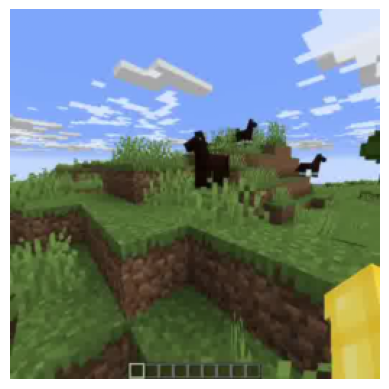

32

In [2]:
from src.data import *
# set batch_size = num_frames
split_data2('data/mc', 'data/mcsplit', 0.995, num_frames=4)
dataset = videoDataset('data/mc', 'data/mcsplit/train.txt', (256, 256))
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

display_image_from_torch_tensor(dataset[0][0])
len(dataset)*4

In [5]:
from src.autoencoder import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myvae = vae().to(device)  

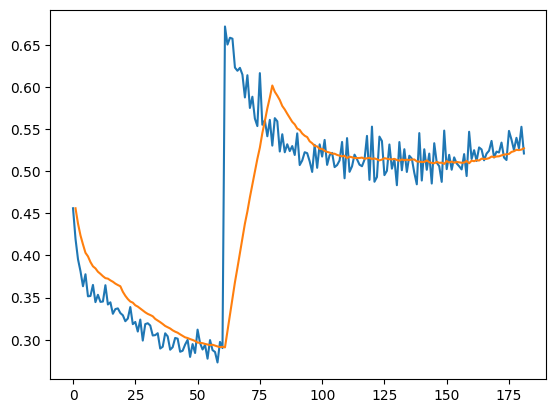

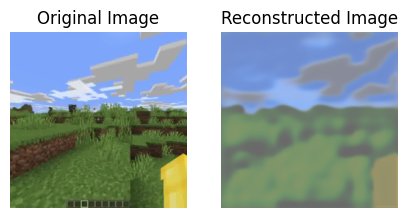

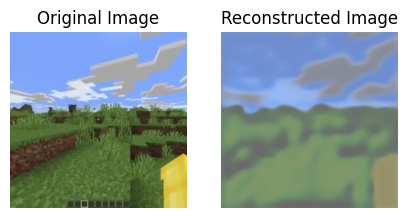

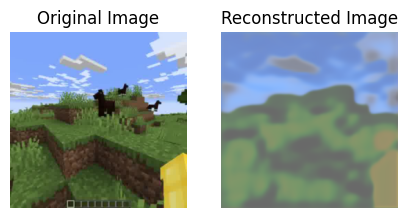

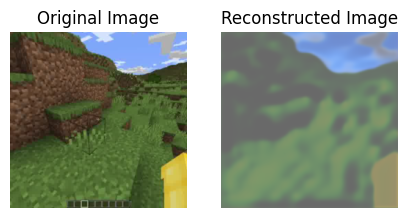

loss: 0.5293, epoch: 91, batch: 1
loss: 0.5293, epoch: 92, batch: 1
loss: 0.5305, epoch: 93, batch: 1


In [ ]:
train(myvae, train_loader, dataset, lr=3e-4, num_epochs=200,
       perceptual_loss=True,
       disc_start=60)

In [20]:
def sample_image(model, dataset, device=None, generator=None):
    model.eval()
    device = device or 'cuda'
    with torch.no_grad():
        torch.manual_seed(generator) if generator else None
        
        random_idx = np.random.randint(0, len(dataset))
        random_idx = torch.randint(0, len(dataset), (1,)).item()
        random_image = dataset[random_idx]
        if random_image.dim() == 5:
            _, _, c, h, w = random_image.shape
            random_image = random_image.view(-1, c, h, w)
        random_image = random_image.to(device)[0].unsqueeze(0)
        loss, reconstructed_image, latent_space = model(random_image)
        
        # Clip the data to the valid range [0, 1]
        min, max = random_image.min(), random_image.max()
        range = max - min
        random_image = (random_image - min) / range
        reconstructed_image = ((reconstructed_image + 1)/2).clamp(0, 1) 

        fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
        
        # Original image
        axes[0].imshow(random_image.squeeze(0).transpose(2, 0).transpose(0, 1).cpu())
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Reconstructed image
        axes[1].imshow(reconstructed_image.squeeze(0).transpose(2, 0).transpose(0, 1).cpu())
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')
        
        plt.show()

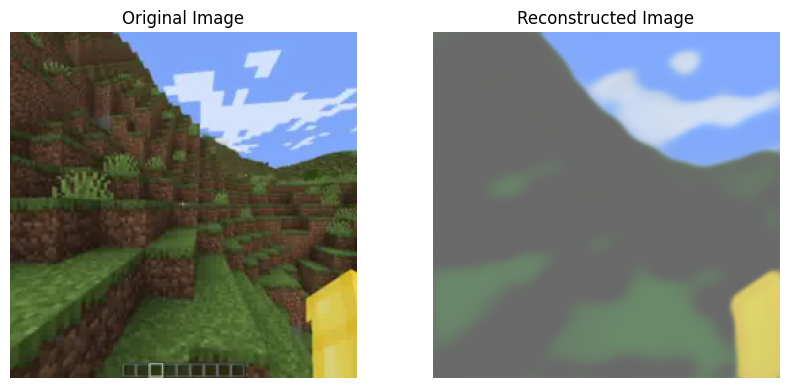

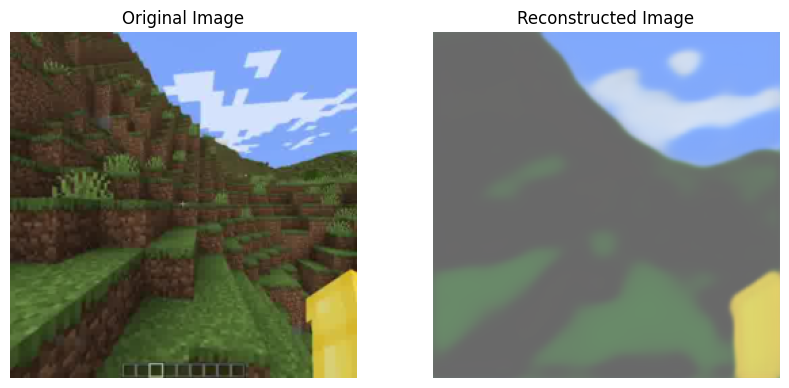

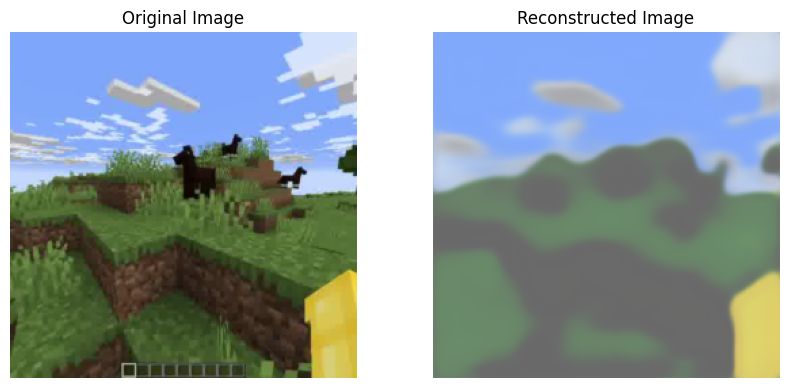

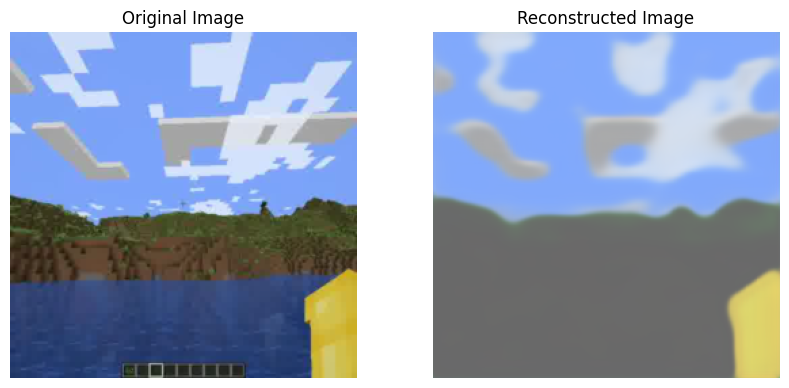

In [21]:
sample_image(myvae, dataset, device)
sample_image(myvae, dataset, device)
sample_image(myvae, dataset, device)
sample_image(myvae, dataset, device) 

In [356]:
from src.utils import *
from src.DiT import *
dit = DiT(num_dit_blocks=12, patch_size=2, dims=512).to(device)
count_parameters(dit)

17.03296M


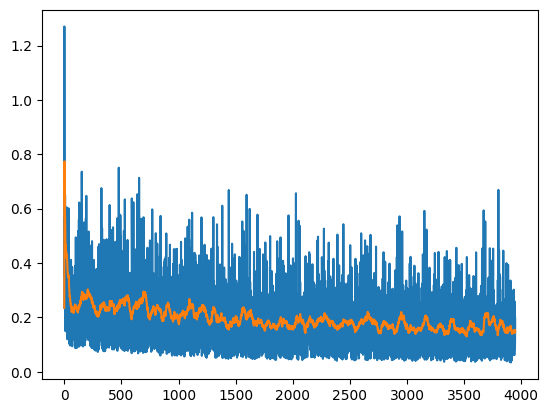

In [361]:
train_denoiser(dit, myvae, train_loader, num_steps=1000, lr=1e-4, num_epochs=20, scheduler='linear')

In [371]:
def diffusion_sampler(vae, dit_model, dataset, num_samples=1, num_steps=10, scheduler='linear'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.eval()
    dit_model.eval()
    img = dataset[0][0].unsqueeze(0).to(device)
    latent = vae.encoder(img).repeat(num_samples, 1, 1, 1)
    latent = torch.randn_like(latent)
    output = vae.decoder(latent)
    if scheduler=='cosine':
        alphas_cum = torch.tensor(get_schedule(num_steps)).to(device).float()
    elif scheduler=='linear':
        linear = LinearNoiseScheduler(num_steps, beta_start=0.0001, beta_end=0.02)
    plt.figure(figsize=(3, 3))
    plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    with torch.no_grad():
        for t in torch.arange(num_steps-1, -1, -1):
            t = t.repeat(num_samples)
            eps =  dit_model(latent, t)
            if scheduler == 'cosine':
                #print(f'Step {t[0]}, alpha: {alphas_cum[t[0]]}')
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = alphas_cum[t]/alphas_cum[t-1] if t[0] > 0 else alphas_cum[t]
                alpha_t = alpha_t.to(device)
                sigma_t = (1 - alpha_t) * (1 - alphas_cum[t-1]) / (1 - alphas_cum[t]).to(device)
                sigma_t = sigma_t ** 0.5
                latent = (latent - (eps * (1 - alpha_t)/torch.sqrt(1 - alphas_cum[t].to(device)))) / torch.sqrt(alpha_t) 
                t = t.view(-1)
            elif scheduler == 'linear':
                sigma_t = 0
                t = t.reshape(-1, 1, 1, 1)
                latent, _ = linear.sample_prev_timestep(latent, eps, t)
                t = t.view(-1)
                            
            if t[0] == 0:
                latent = latent
            else:   
                z = torch.randn_like(latent).to(device) 
                latent = latent + sigma_t * z
            output = vae.decoder(latent * 3.5 + 2)
            mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1).to(device)
            output = (output * std + mean).clamp(0, 1) 
            output = torch.clamp(output, 0, 1)
            if t[0] % (num_steps//10) == 0:
                print(f'Step {t[0]}')
                fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
                for i in range(num_samples):
                    axes[i].imshow(output[i].permute(1, 2, 0).cpu().numpy())
                    axes[i].axis('off')
                plt.show()
    return output

In [377]:
config = {
    'num_dit_blocks': 12,
    'patch_size': 2,
    'dims': 512,
    'scheduler': 'linear'
}
save_model_with_config(dit, 'weights/mc_dit0.1.pth', config)
torch.save(myvae.state_dict(), 'weights/mc_vae0.1.pth')
torch.save(dataset, 'weights/mc_dataset0.1.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16997123..0.26967648].


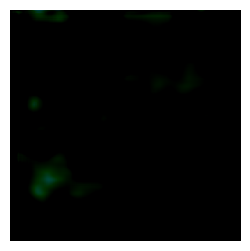

Step 900


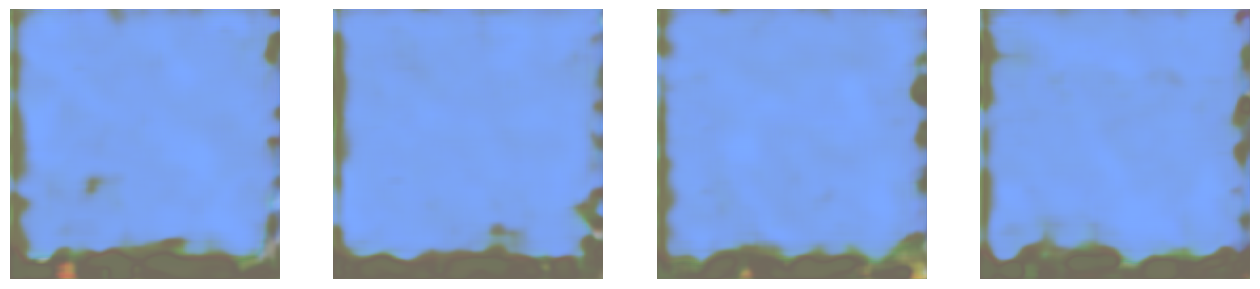

Step 800


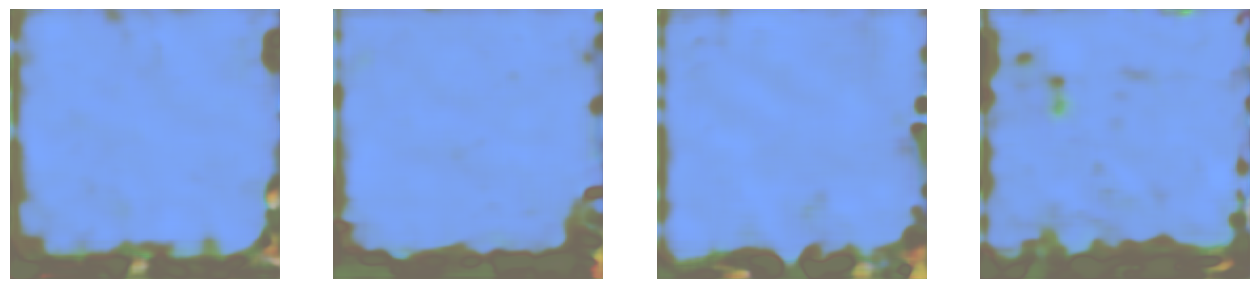

Step 700


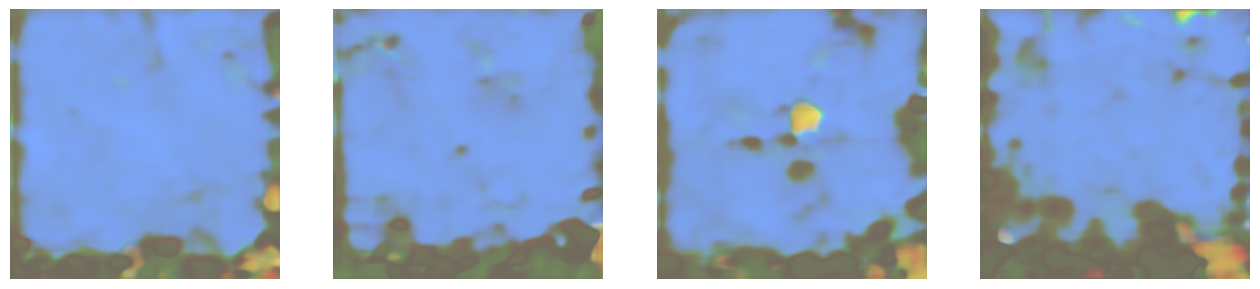

Step 600


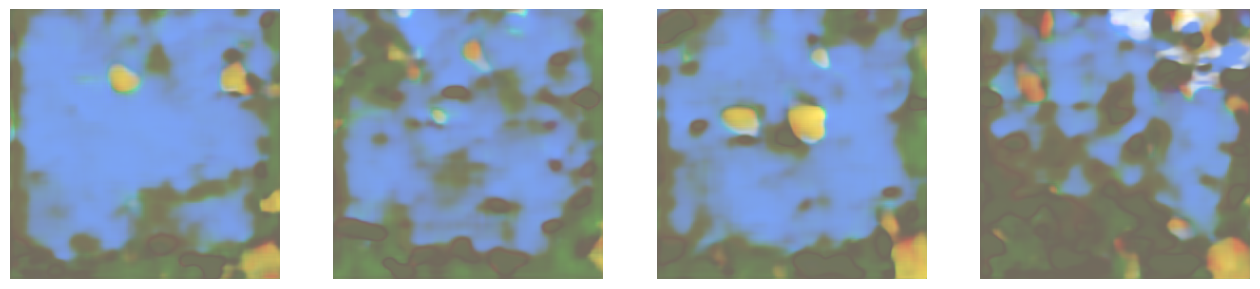

Step 500


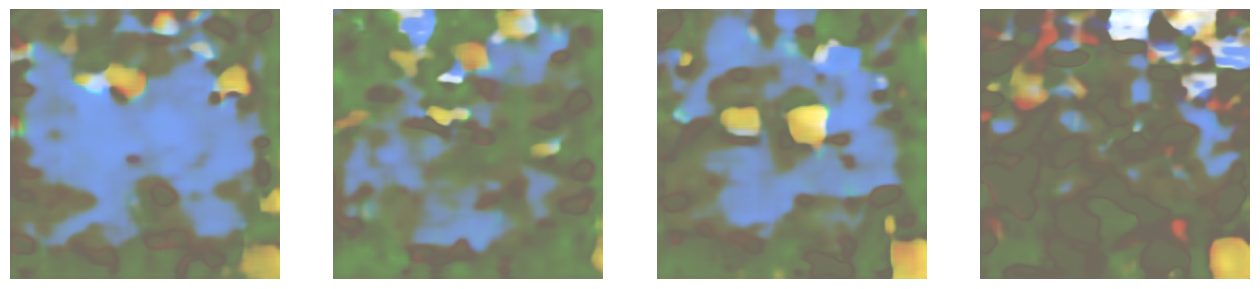

Step 400


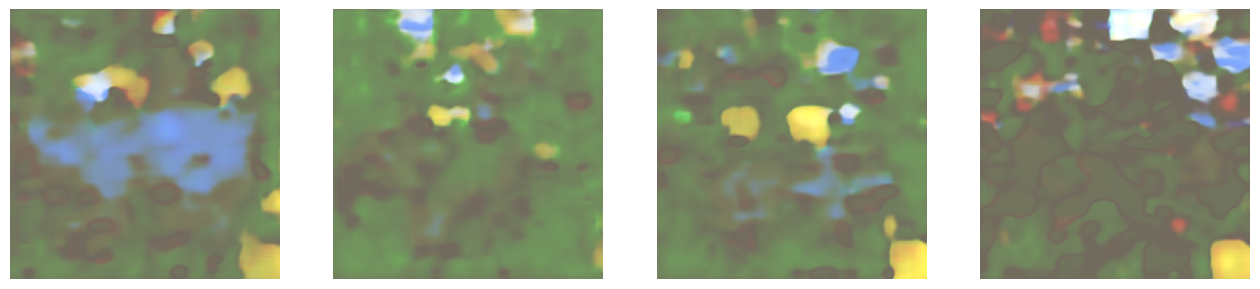

Step 300


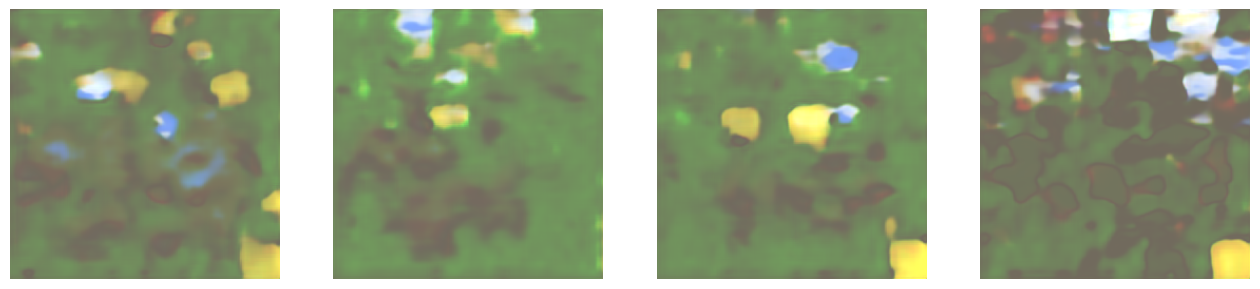

Step 200


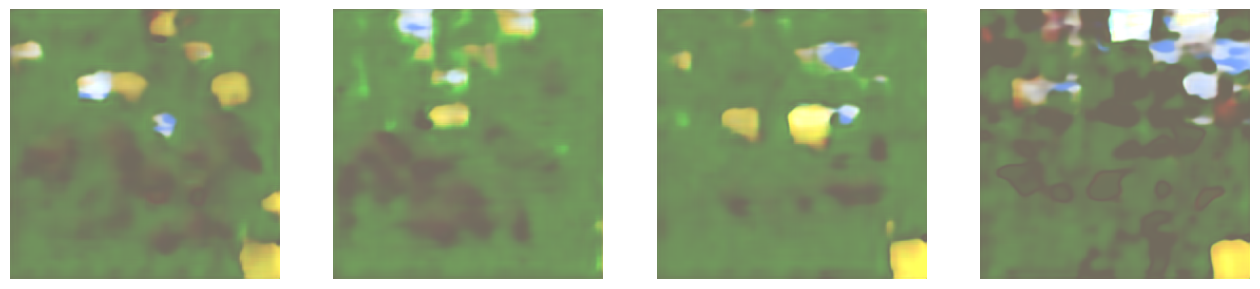

Step 100


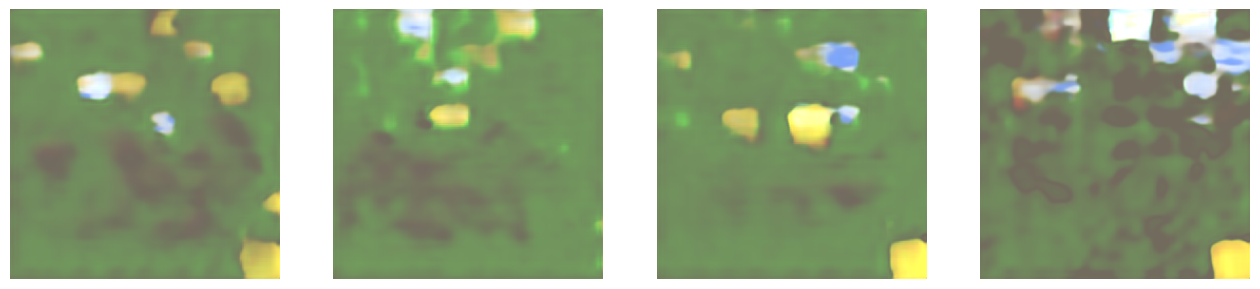

Step 0


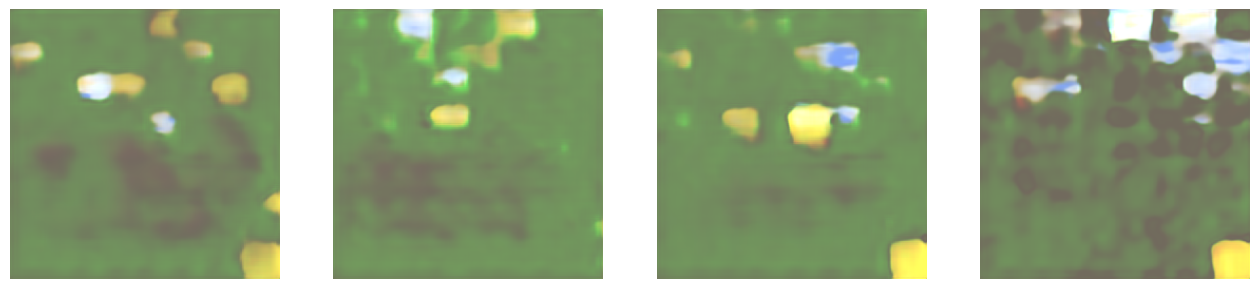

In [372]:
sample = diffusion_sampler(myvae, dit, dataset, num_samples=4, num_steps=1000, scheduler='linear')